# 2.  Batch download & processing .nc files from online ressource - Temperature 

Network common data form (NetCDF) is commonly used to store multidimensional geographic data. Some examples of these data are temperature, precipitation, and wind speed. Variables stored in NetCDF are often measured multiple times per day over large (continental) areas. With multiple measurements per day, data values accumulate quickly and become unwieldy to work with. When each value is also assigned to a geographic location, data management is further complicated. NetCDF provides a solution for these challenges. 

> According to Wunsch et al . 2022, we will use the [HYRAS Dataset (Hydrometeorologische Rasterdatensätze)](https://www.dwd.de/DE/leistungen/hyras/hyras.html) provided by the [Deutsche Wetterdienst DWD](https://www.dwd.de/DE/Home/home_node.html).
The respective data is open access and can be easily downloaded [here](https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/).


#### Processing NetCDF Files

The **Climate Data Operator (CDO)** is a command line tool, which can be easily downloaded and installed from the [ISIMIP](https://www.isimip.org/protocol/preparing-simulation-files/cdo-help/). CDO is a collection of command line Operators to manipulate and analyse Climate and NWP model Data. You can find a documentation of all the commands [here](https://duncanjg.wordpress.com/wp-content/uploads/2008/02/cdo_refcard.pdf).

#### How to read NetCDF files to Python

I recommend the following ressources on NetCDF processing in Python provided by [towardsdatescience](https://towardsdatascience.com/read-netcdf-data-with-python-901f7ff61648) and the [NOAA](https://www.star.nesdis.noaa.gov/atmospheric-composition-training/python_netcdf4.php).

We will mostly use the [xarray Python library](https://docs.xarray.dev/en/stable/). xarray is the most common and easiest way of processing netCDF and similiar data formats.

#### Installation

The easiest way to get going is to install via `pip install xarray`. (or if you use the conda package manager `conda install -c conda-forge xarray` in the terminal).

Lets import all needed libraries first ...

In [5]:
#  First, lets import all needed libraries
from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import netCDF4 
import xarray as xr
import os, sys
import geopandas as gpd
import rioxarray


... and set the working directory:

In [2]:
import os, sys
import wget 


pwd = os.getcwd()
print(pwd)

/Users/marie-christineckert/Nextcloud/TU/Lehre/AktuelleAnwendungen_SoSe24/7_GW_Model_Example


### 2.1. Naming Convention

The data we download from Hyras is named after a **naming convention**. Meaning, all file names follow the same structure. That makes batchdownloading them pretty handy!

In [3]:
## sample name file: tas_hyras_5_1951_v5-0_de.nc

year = 1981
file_start_name = "tas_hyras_5_"
file_end_name = "_v5-0_de"
file_ext_name = ".nc"

file_name = f"{file_start_name}{year}{file_end_name}{file_ext_name}"
file_name

'tas_hyras_5_1981_v5-0_de.nc'

Cool! Now that we know the file name structure, we can easily plug that into the following download loop.

### 2.2. Batch Downloading

Here, we will create a new subdirectory, where all our needed data gets stored. That should keep our working directory nice and tidy. 

Enter `start_year` and `end_year` as desired. Here, I only entered 3 years for the sake of simplicity. 
> **Note, that downloading might take some time, that the files are pretty large and that you want to avoid memory error!** To make things faster depending on your hardware, you might want to consider downloading & preprocessing the data in smaller batches.

In [4]:
## set current WD
os.chdir(pwd)

## specify years to download
start_year = 1990 #yyyy
end_year = 2005 #yyy
## specify wd
path = "data/"
download_dir = os.path.join(path, "HYRAS_Data")
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

## sample link to hydras data: https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/air_temperature_mean/
base_site = "https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/air_temperature_mean/"
## sample name file: tas_hyras_5_1951_v5-0_de.nc

##########################

for year in range (start_year, end_year+1,1):
    file_start_name = "tas_hyras_5_"
    file_end_name = "_v5-0_de"
    file_ext_name = ".nc"
    file_name = f"{file_start_name}{year}{file_end_name}{file_ext_name}"
    url = f"{base_site}/{file_name}"
    print(f"Downloading .....{file_name}")
    wget.download(url, download_dir)
    print(f"{file_name}.....Downloaded successfully")
print("All Data successfully downloaded")

100% [......................................................] 5397837 / 5397837tas_hyras_5_1990_v5-0_de.nc.....Downloaded successfully
100% [......................................................] 5451936 / 5451936tas_hyras_5_1991_v5-0_de.nc.....Downloaded successfully
100% [......................................................] 5413266 / 5413266tas_hyras_5_1992_v5-0_de.nc.....Downloaded successfully
100% [......................................................] 5393690 / 5393690tas_hyras_5_1993_v5-0_de.nc.....Downloaded successfully
100% [......................................................] 5350503 / 5350503tas_hyras_5_1994_v5-0_de.nc.....Downloaded successfully
100% [......................................................] 5428432 / 5428432tas_hyras_5_1995_v5-0_de.nc.....Downloaded successfully
100% [......................................................] 5422811 / 5422811tas_hyras_5_1996_v5-0_de.nc.....Downloaded successfully
100% [.................................................

### 2.3. Subset data to Area of Interest (AOI)


Here, we subset the dataset to the area of interest. We want to avoid memory error with large datastets. Cutting them to AOI makes them considerably smaller.

In [5]:
## check for right direcotry

os.getcwd()

## change it if needed back to pwd
#os.chdir(pwd)
#pwd

'/Users/marie-christineckert/Nextcloud/TU/Lehre/AktuelleAnwendungen_SoSe24/7_GW_Model_Example'

To subset the freshly downloaded Netcdf files to AOI, we will process them as **xarrays.** Xarray is an open source project and Python package that introduces labels in the form of dimensions, coordinates, and attributes on top of raw NumPy-like arrays, which allows for more intuitive, more concise, and less error-prone user experience ([Xarray.dev](https://xarray.dev/#))

> [Nice documentation of xarray](https://docs.xarray.dev/en/v0.7.2/data-structures.html)

Define the new output directory where we want to store the clipped `.nc` files: 

In [6]:
path = "data/"

#output_dir = os.path.join(path, "HYDRAS-data_clip") # 
output_dir = "data/HYRAS-data_clip/"#

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

input_dir = os.path.join(path, "HYRAS_Data")
input_dir


'data/HYRAS_Data'

#### 2.3.1. Download shapefiles - Federal States germany 

Ok, but how do we know the area, we need to clip the .nc files to? We are dealing with raster data here and we need to find the raster cells corresponding to our AOi (e.g. federal states in germany). 

The easiest way to do this is to download a shapefile of that specific federal state, get its total extent and use that extent to clip our .nc file to the AOI. 

Thankfully, there is OSM! The [GeoFabrik](https://download.geofabrik.de/europe/germany.html) provides a ton of worldwide shapefiles, which are free and open source. You can download the shapefiles of the AOI there and proceed with further processing. If you cant find your desired federal states shapefile, you can also have a look on [GADM](https://gadm.org). They provide worlwide shapefiles and mpas based on administrative boundaries

Our exemplary AOI will be brandenburg. These shapefiles was provided by the Geobroker Atkis of Brandenburg.



In [7]:
brandenburg = gpd.read_file(
    "data/brandenburg_shapefiles/GRENZE_184201-5683624_bebb.shp", crs="epsg:4326")


<Axes: >

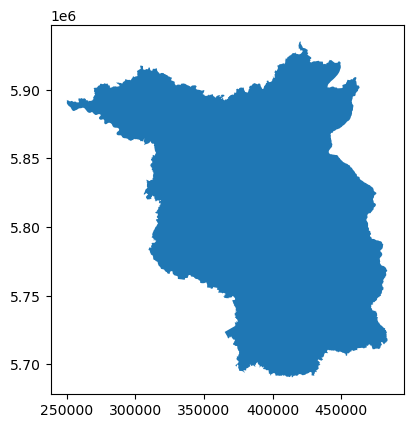

In [8]:
brandenburg.plot()

#### 2.3.2. Set the right CRS

Remember the EPSG and Coordinate systems from the previous script? We can only intersect different geogrpahical data if they are in the same crs. Therefore, we need to adapt the crs of the berlin shapefile to the crs of our .nc files! 

> This is a **really fundamental step** and will lead to error messages if ignored!

In [10]:
## change shapefile crs to crs of Hyras dataset
brandenburg = brandenburg.to_crs('epsg:3034') ## change crs to crs of nc files


Now, we are ready to get the total extent of the AOI shapefile. 

In [11]:
minx, miny, maxx, maxy = brandenburg.total_bounds
miny, maxy, minx, maxx

(2737571.0946294293, 2973891.9184935074, 4081889.1148089226, 4318591.44006166)

Change input working directory to the Hyras data folder. 

In [12]:
os.chdir(pwd)
os.chdir(input_dir)

In [13]:
input_dir

'data/HYRAS_Data'

Sanity check: where will we store the clipped files?

In [14]:
output_dir, pwd

('data/HYRAS-data_clip/',
 '/Users/marie-christineckert/Nextcloud/TU/Lehre/AktuelleAnwendungen_SoSe24/7_GW_Model_Example')

You may easily execute the cell below, where we will crop all .nc files to AOi batchwise!

In [15]:
for filename in os.listdir():
    if filename.endswith('.nc'):
        file_name, file_ext = os.path.splitext(filename)
        new_filename = f"{file_name}_clip{file_ext}"
        new_ncfile = f"{pwd}/{output_dir}/{new_filename}"
        print(f"Now reading {filename}")
        
        ###################### 
        print("Now cropping the data from the main netcdf file to be subset!")
       # fp='data/HYDRAS_Data/tas_hyras_5_1981_v5-0_de.nc'
        data = xr.open_dataset(filename)
        data_crop  = data.sel(x=slice(minx, maxx), y=slice(miny, maxy)) 
        print("Cropping completed!")  
        ######################
        print("creating new netcdf file!")
       # my_file = netCDF4.Dataset(, 'w', format  = )
        data_crop.to_netcdf(path=new_ncfile, mode='w', format="NETCDF4")
print("##################")
print("! Subseting of netcdf file is successful !")
print("##################") 

Now reading tas_hyras_5_1999_v5-0_de.nc
Now cropping the data from the main netcdf file to be subset!
Cropping completed!
creating new netcdf file!
Now reading tas_hyras_5_1994_v5-0_de.nc
Now cropping the data from the main netcdf file to be subset!
Cropping completed!
creating new netcdf file!
Now reading tas_hyras_5_2000_v5-0_de.nc
Now cropping the data from the main netcdf file to be subset!
Cropping completed!
creating new netcdf file!
Now reading tas_hyras_5_2005_v5-0_de.nc
Now cropping the data from the main netcdf file to be subset!
Cropping completed!
creating new netcdf file!
Now reading tas_hyras_5_1991_v5-0_de.nc
Now cropping the data from the main netcdf file to be subset!
Cropping completed!
creating new netcdf file!
Now reading tas_hyras_5_1996_v5-0_de.nc
Now cropping the data from the main netcdf file to be subset!
Cropping completed!
creating new netcdf file!
Now reading tas_hyras_5_2002_v5-0_de.nc
Now cropping the data from the main netcdf file to be subset!
Cropping c

#### Sanity check

plot time sries for a spiecific location. Did everything work out fine?

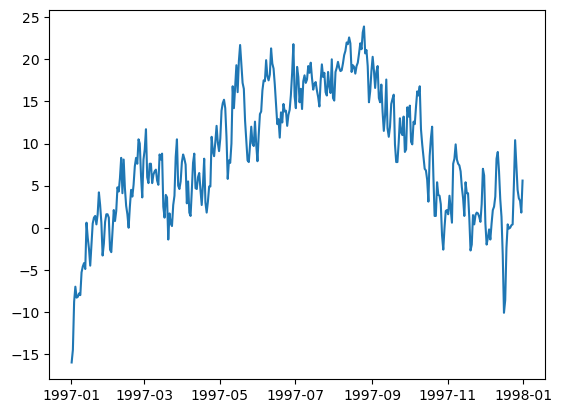

In [16]:
data_crop.isel(x=1, y= 1)# for one specific location
plt.plot(data_crop.isel(x=1, y= 1)['time'].values, 
         data_crop.isel(x=1, y= 1)['tas'].values)

#### 2.3.3 Plotting

> Lets plot the tas variables again to see the spatial extent of the subset

<Axes: title={'center': 'time = 1997-07-20T12:00:00'}, xlabel='X Coordinate Of Projection for\nCell Center [m]', ylabel='Y Coordinate Of Projection for\nCell Center [m]'>

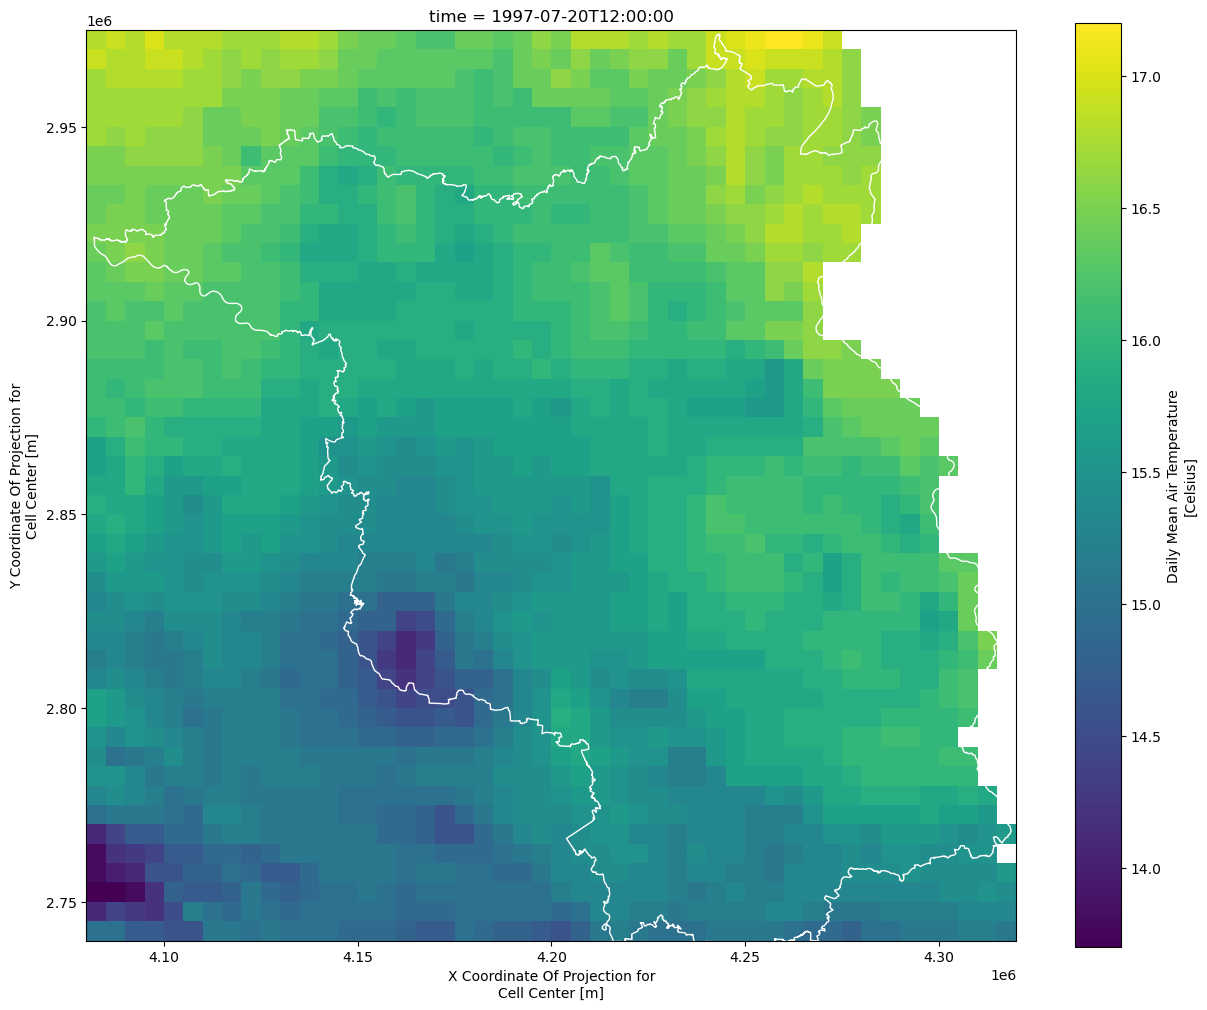

In [18]:
data_crop2d = data_crop.isel(time=200)

fig, ax = plt.subplots(figsize=(15, 12))



data_crop2d.tas.plot.pcolormesh(x='x', y='y', ax=ax)
brandenburg.plot(ax = ax, edgecolor='white', color='none')

-----

### 2.4. Stacking 

Next, we want to produce on time series from all netCDF files that we previously downloaded. The first step is to stack multiple netcdf files into one. 

> For the sake of simplicity you might want to do that using the **CDO programm**. 
>
> The following thread provides an instruction on how to do this: https://code.mpimet.mpg.de/boards/1/topics/908
>
> Via the terminal you can use the following command:
> `cdo -f nc2 mergetime *.nc outfile.nc`

In [19]:
## reset WD: 
import glob
pwd


'/Users/marie-christineckert/Nextcloud/TU/Lehre/AktuelleAnwendungen_SoSe24/7_GW_Model_Example'

In [20]:
os.chdir(pwd)

The code below merges the .nc files in python and saves it into a new file:

In [21]:
## merge all files into one

ds = xr.merge([xr.open_dataset(f) for f in glob.glob('data/HYRAS-data_clip/*.nc')])


In [22]:
## define new file name 

min_year = ds.variables['time'].values.min().astype('datetime64[Y]').astype(int)+ 1970
max_year = ds.variables['time'].values.max().astype('datetime64[Y]').astype(int)+ 1970

file_start_name = "tas_hyras_5_"
file_end_name = "_v5-0_de"
file_ext_name = ".nc"

file_name = f"{file_start_name}{file_end_name}_clip_merged_{min_year}_to_{max_year}{file_ext_name}"

new_ncfile = f"{pwd}/{output_dir}/{file_name}"
print(new_ncfile)

/Users/marie-christineckert/Nextcloud/TU/Lehre/AktuelleAnwendungen_SoSe24/7_GW_Model_Example/data/HYRAS-data_clip//tas_hyras_5__v5-0_de_clip_merged_1990_to_2005.nc


In [23]:
## safe to new file

ds.to_netcdf(path=new_ncfile, mode='w', format="NETCDF4")

In [24]:
ds

<xarray.Dataset> Size: 53MB
Dimensions:             (time: 5844, x: 48, y: 47, bnds: 2)
Coordinates:
  * time                (time) datetime64[ns] 47kB 1990-01-01T12:00:00 ... 20...
  * x                   (x) float32 192B 4.082e+06 4.088e+06 ... 4.318e+06
  * y                   (y) float32 188B 2.742e+06 2.748e+06 ... 2.972e+06
    lon                 (y, x) float64 18kB 11.23 11.3 11.38 ... 14.88 14.95
    lat                 (y, x) float64 18kB 51.46 51.46 51.46 ... 53.51 53.51
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 94kB 1990-01-01 ... 2006-...
    x_bnds              (x, bnds) float32 384B 4.08e+06 4.085e+06 ... 4.32e+06
    y_bnds              (y, bnds) float32 376B 2.74e+06 2.745e+06 ... 2.975e+06
    crs_HYRAS           int32 4B 1
    tas                 (time, y, x) float32 53MB -1.3 -1.3 -1.6 ... nan nan nan
    number_of_stations  (time) float64 47kB 1.569e+03 1.569e+03 ... 1.486e+03
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    institution:            Deutscher Wetterdienst (DWD)
    title:                  gridded_temperature_dataset_(HYRAS-DE TAS)
    creation_date:          created at 2022-12-04 00:40:13
    filename:               tas_hyras_5_1990_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tas_v5.0_1990_day_00638BEC6D

In [25]:
# Replace 'your_file.nc' with the path to your NetCDF file
file_path = f'data/HYRAS-data_clip/{file_name}'
# Read the NetCDF file into an xarray Dataset
nc = xr.open_dataset(file_path)



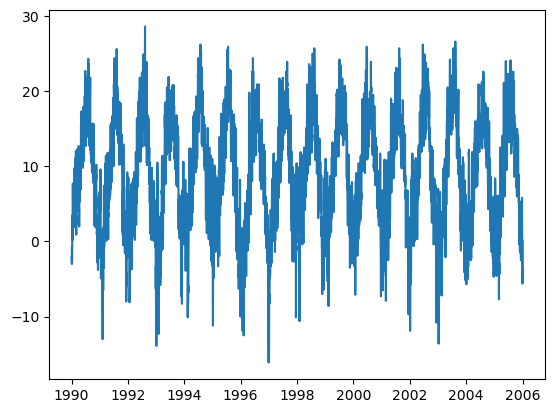

In [26]:
#nc.isel(x=1, y= 1)# for one specific location
plt.plot(nc.isel(x=1, y= 1)['time'].values, 
         nc.isel(x=1, y= 1)['tas'].values)

Nice! Now we got a continuous time series extracted from the .nc files! That was quite a bit of work!

We are now ready for the next script, where we will extract time series at specific well locations.

***